In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import warnings
warnings.simplefilter('ignore')

/home/nathan/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nathan/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nathan/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nathan/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nathan/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nathan/envs/tf

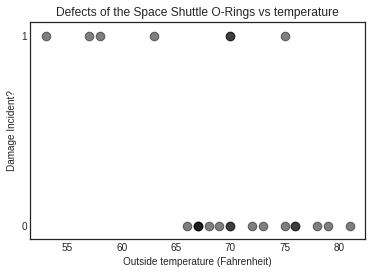

In [2]:
# Straight from the book:
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# #plot it, as a function of tempature (the first column)
# print("Temp (F), O-Ring failure?")
# print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

In [3]:
temperature_data = challenger_data[:, 0]
failed_data = challenger_data[:, 1]
n_data = len(temperature_data)

def model():
    alpha = tfp.edward2.Normal(name='alpha', loc=0., scale=10.)
    beta = tfp.edward2.Normal(name='beta', loc=0., scale=1.)
    p = 1. / (1. + tf.exp(beta*temperature_data + alpha))
    failed = tfp.edward2.Bernoulli(name='failed', probs=p)
    
    return failed

log_joint = tfp.edward2.make_log_joint_fn(model)
def objective_fn(alpha_in, beta_in):
    return log_joint(
        alpha=alpha_in,
        beta=beta_in,
        failed=failed_data
    )

In [4]:
mh = tfp.mcmc.MetropolisHastings(
    tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
        target_log_prob_fn=objective_fn,
        step_size=0.001,
        num_leapfrog_steps=3))

# hmc = tfp.mcmc.HamiltonianMonteCarlo(
#         objective_fn,
#         step_size=0.01,
#         num_leapfrog_steps=3)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=10000,
    num_burnin_steps=1000,
    current_state=[
        tfp.edward2.Normal(name='qalpha', loc=0., scale=10.),
        tfp.edward2.Normal(name='qbeta', loc=0., scale=1.),
    ],
    kernel=mh)

[alpha_trace, beta_trace] = states
accepted = kernel_results.is_accepted

In [5]:
with tf.Session() as sess:
    alpha_posterior, beta_posterior, accepted_ = sess.run(
        [alpha_trace, beta_trace, accepted])
    
print('alpha:', alpha_posterior.mean(), alpha_posterior.std())
print('beta:', beta_posterior.mean(), beta_posterior.std())
print(accepted_.sum())

alpha: -9.146373 0.15671568
beta: 0.14676893 0.008062761
9998


Text(0.5,1,'Beta')

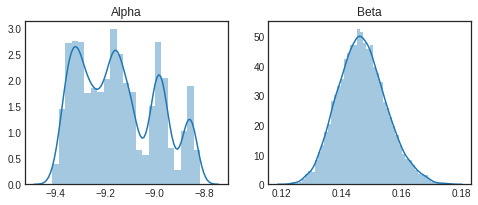

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
sns.distplot(alpha_posterior, ax=axs[0]); axs[0].set_title('Alpha')
sns.distplot(beta_posterior, ax=axs[1]); axs[1].set_title('Beta')

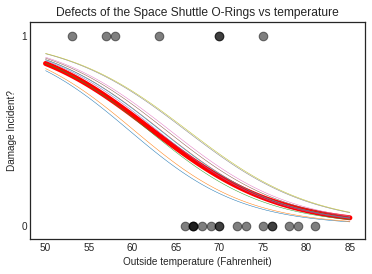

In [36]:
# beta_average = beta_posterior.mean()
# alpha_average = alpha_posterior.mean()

x_ = np.linspace(50, 85, 100)
logistic_fn = 1. / (1. + np.exp(x_[:,None] * beta_posterior + alpha_posterior)).T

mean_logistic_fn = logistic_fn.mean(axis=0)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.plot(x_, mean_logistic_fn, lw=5, c='r')
for k in range(10):
    plt.plot(x_, logistic_fn[k, :], lw=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");


In [29]:
logistic_fn.shape

(100, 10000)

In [24]:
x_[:,None].shape

(100, 1)